> # Projet Seam Carving - Théorie des Graphes
## Rapport 
**Auteur** : Salek Talha  
**Date** : 16/01/2026  
**Cours** : Théorie des Graphes  
**Encadrant** : [Nom du prof]

## Objectif
L'objectif de ce projet est de reussir à reduire l'image suivant les zones à basse énergie. Pour cela, nous avons procedé à: 
1. calculer d'abord la carte d'énergie de l'image(format numpy),
2. de chercher la jointure la plus basse,
3. supprimer cette jointure,
4. repeter l'étape 2,3 k fois.


## Modélisation en Théorie des Graphes
Pour la modélisation, nous avons:
- **Sommets** = pixels de l'image
- **Arêtes** = connexions entre pixels adjacents (haut → bas)
- **Poids** = énergie du pixel d'arrivée

----

In [90]:
# imports de base
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt

## Fonction pour charger l'image

In [ ]:
def charge_img(chemin,size=(256,256)): # chemin designe le chemin (path) de l'image dans le répertoire
    img = Image.open(chemin) 
    # img = img.resize(size) # redimensionne l'image en 256 x 256
    return np.array(img)

image2 = charge_img("image2.jpg")
print(image2.shape)
print(image2.dtype)

(968, 1428, 3)
uint8


## Fonction pour afficher l'image

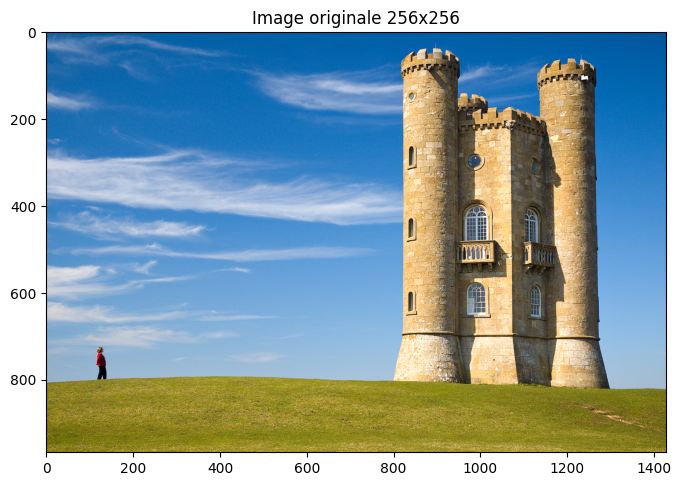

In [ ]:
def affiche_img(image,title="Image"):
    plt.figure(figsize=(8,8))  # format 8 pouces pour avoir un carré bien parfait
    plt.imshow(image)
    plt.title(title)
    plt.axis('on')
    plt.show()

affiche_img(image2) 

### Vérifier les pixels

In [ ]:
print(image2[:3, :3])
print("\nDimensions:", image2.shape)
print("Hauteur:", image2.shape[0], "pixels")
print("Largeur:", image2.shape[1], "pixels")
print("Canaux:", image2.shape[2]) # mettre cette ligne en commentaire si l'image n'est pas en couleur

[[[  0  93 157]
  [  8  93 158]
  [  6  94 158]]

 [[  1  95 159]
  [  2  91 159]
  [  5  95 157]]

 [[ 17  97 160]
  [ 11  94 160]
  [ 18  97 156]]]

Dimensions: (968, 1428, 3)
Hauteur: 968 pixels
Largeur: 1428 pixels


## Calcul de la carte d'énergie
#### Fonction pour convertir une image rgb en gris....si l'image est déjà en gris pas besoin d'executer cette fonction

In [ ]:
def rgb_to_gris(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114]) #c'est une formule standard pour convertir une image RGB en gris

In [ ]:
def calcule_energie(image):
    if len(image.shape) == 3:
        gris = rgb_to_gris(image)  # si l'image n'est pas en gris
    else:
        gris = image.astype(float)  # si elle est en gris
    dy,dx = np.gradient(gris.astype(float)) # float pour éviter les overflow
                                            # grad vertical (dy): différence entre pixels haut/bas
                                            # grad horizontal (dx): différence entre pixels gauche/droite
    energie = np.abs(dx) + np.abs(dy)       # energie est la somme des valeurs absolue des gradients
    return energie

In [ ]:

energie = calcule_energie(image2) 
print(energie.shape)
print(f"Min énergie: {energie.min():.2f}, Max énergie: {energie.max():.2f}")

(968, 1428)
Min énergie: 0.00, Max énergie: 240.91


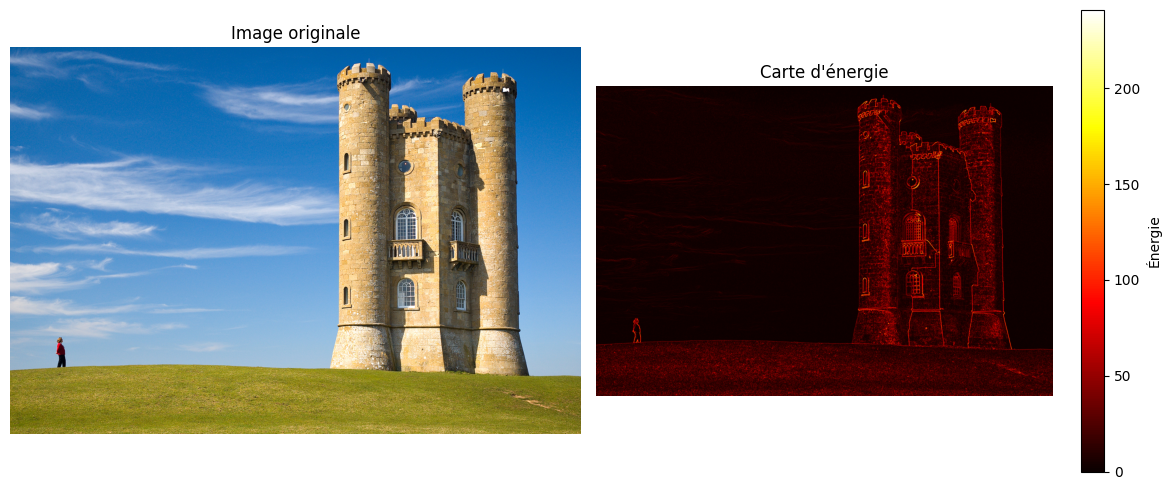

In [ ]:
plt.figure(figsize=(12, 5))  # figure de largeur=12 et hauteur = 5

plt.subplot(1, 2, 1)    # "1 ligne, 2 colonnes, position 1" ---- utiliser pour afficher la 1ere image
plt.imshow(image2)
plt.title("Image originale")
plt.axis('off')

plt.subplot(1, 2, 2)    # "1 ligne, 2 colonnes, position 2" ---- utiliser pour afficher la 2eme image
# Afficher l'énergie avec une colormap 'hot' (rouge = haute énergie)
affiche_energie = plt.imshow(energie, cmap='hot')
plt.title("Carte d'énergie")
plt.axis('off')
plt.colorbar(affiche_energie, label='Énergie')

plt.tight_layout()
plt.show()

## Recherche de la jointure(seam) verticale de plus basse énergie

In [ ]:
def find_verticale_seam(energie):
    h,w = energie.shape
    cout = energie.copy().astype(float) # tableau des coûts cumulé
    
    #gtableau pour le backtracking (d'où on vient)
    # -1 = vient de gauche, 0 = du centre, 1 = de droite
    backtrack = np.zeros((h,w),dtype=int) 
    
    # Initialisation: première ligne = énergie de départ
    # Pas besoin de modifier pour la ligne 0
    for i in range(1,h): # on commence à la ligne 1
        for j in range(w):
            gauche = cout[i-1,j-1] if j>0 else float('inf')
            milieu = cout[i-1,j]
            droite = cout[i-1,j+1] if j<w-1 else float('inf')
            cout_min= min(gauche,milieu,droite) #trouver le minimum
            cout[i,j] = energie[i,j] + cout_min # mis à jour du cout
            
            #sauvegarder d'ou on vient pour le retour(backtracking)
            if cout_min == gauche:
                backtrack[i,j] = -1
            elif cout_min == milieu:
                backtrack[i,j]= 0
            else:
                backtrack[i,j] = 1
                
    seam_fin = np.argmin(cout[-1,:]) # trouver le pixel de départ sur la derniere ligne
    # backtrack pour reconstruire le chemin complet
    seam = [seam_fin]
    for i in range(h-1,0,-1): #remonter de la derniere à la premiere ligne
        j=seam[-1]
        direction = backtrack[i,j]
        seam.append(j+direction)
        
    seam.reverse() # inverser pour avoir le chemin du haut en bas
    
    return seam,cout       
            
        
    

In [ ]:
# Test sur notre image
seam, cost_matrix = find_verticale_seam(energie)

print(f"Seam trouvée ! Longueur: {len(seam)} pixels")
print(f"Premiers indices: {seam[:5]}...")
print(f"Derniers indices: {seam[-5:]}")

# Vérification
print(f"\nVérification:")
print(f"- Taille seam: {len(seam)} (doit être {energie.shape[0]})")
print(f"- Min seam index: {min(seam)}")
print(f"- Max seam index: {max(seam)} (doit être < {energie.shape[1]})")

Seam trouvée ! Longueur: 968 pixels
Premiers indices: [np.int64(1369), np.int64(1368), np.int64(1369), np.int64(1370), np.int64(1369)]...
Derniers indices: [np.int64(1412), np.int64(1413), np.int64(1413), np.int64(1412), np.int64(1413)]

Vérification:
- Taille seam: 968 (doit être 968)
- Min seam index: 1314
- Max seam index: 1414 (doit être < 1428)


## Visualisation de la seam

In [ ]:
def visualisation_seam(image, seam, color=(255, 0, 0)):
    
            # Dessine la seam en rouge sur l'image
    img_avec_seam = image.copy()
    h, w = img_avec_seam.shape[:2]
    
    for i in range(h):
        j = seam[i]
        # Assurer que j est dans les limites
        j = max(0, min(j, w-1))
        
        # Dessiner un point rouge sur la seam
        img_avec_seam[i, j] = color
    
    return img_avec_seam


# Afficher l'image avec la seam
image_avec_seam = visualisation_seam(image2, seam)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image2)
plt.title("Image originale")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(energie, cmap='hot')
plt.title("Carte d'énergie")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_avec_seam)
plt.title("Seam trouvée (en rouge)")
plt.axis('off')

plt.tight_layout()
plt.show()

## Fonction qui supprime une jointure(seam) 

In [ ]:
def supp_seam(image,seam):
    h,w = image.shape[:2]
     # creation de la nouvelle image
    if len(image.shape) == 3: # image en couleur
        nouvelle_image = np.zeros((h,w-1,3), dtype=image.dtype)
        for i in range(h):
            j= seam[i]
            nouvelle_image[i,:,:] = np.delete(image[i,:,:],j,axis=0)
    else: #image en gris
        nouvelle_image= np.zeros((h,w-1),dtype=image.dtype)
        for i in range(h):
            j = seam[i]
            nouvelle_image[i,:] = np.delete(image[i,:],j)
    
    return nouvelle_image

print("Taille avant",image2.shape[1],image2.shape[0])
res= supp_seam(image2,seam)

plt.imshow(res)
print("Taille après"res.shape[1],res.shape[0])

## Fonction qui supprime K fois 

In [ ]:
def multiple_seam(image,k_global,seams_intermediaire = False): # si False alors la sauvegarde des seams intermediaire n'auras pas lieu
    img_courante = image.copy() #image courante
    imgs_intermediaires = [] # liste des images avec seams 
    historique_seams = [] #un historique des jointures
    
    
    if seams_intermediaire:
        image_accum_rouge = image.copy()  # image_accum_rouge va contenir tous les seams sur une même image
    else:
        image_accum_rouge = None    
        
    print(f"En train de réduire l'image....")
    
    #calcule de l'energie
    for k in range(k_global):
        energie = calcule_energie(img_courante) # on calcule l'énergie
        seam,cout = find_verticale_seam(energie)  # recherche de la seam maximale
        historique_seams.append(seam) 
        
        if seams_intermediaire and (k<5 or k % 10 ==0 or k==k_global-1): 
            img_avec_seam = visualisation_seam(img_courante,seam,color=[255,0,0]) 
            imgs_intermediaires.append((k,img_avec_seam.copy()))  # on sauvegarde l'image avec seam dans la liste
    
        # Superposer cette seam en rouge sur l'image résultat
        if seams_intermediaire and image_accum_rouge is not None:
            h, w = image_accum_rouge.shape[:2]
            
            # Approximation simple : on décale un peu vers la droite
            # pour tenir compte des suppressions précédentes
            decalage = min(k, 50)  # Décale jusqu'à 50 pixels max
            
            for i in range(min(len(seam), h)):
                j_original = seam[i] if i < len(seam) else seam[-1]
                j_original = max(0, min(j_original + decalage, w - 1))
                
                # Dessiner en rouge
                image_accum_rouge[i, j_original] = [255, 0, 0]
                    
        # suppression de la seam             
        img_courante = supp_seam(img_courante,seam) 
        if k==0 or (k+1)%10 == 0 or k == k_global-1:
            print(f"k={k}") # voir la progression de k
            
    print("Processus terminé !")
    print(f"Avant réduction, les dimensions étaient:{image.shape[0]}x{image.shape[1]}")
    print(f"Après réduction, les dimensions sont:{img_courante.shape[0]}x{img_courante.shape[1]}")
        
    return img_courante, imgs_intermediaires,historique_seams,image_accum_rouge
    

## Fonction qui affiche les images avec seams

In [ ]:
def affichage_final(image_original,resulat,intermediaire,k):
    plt.figure(figsize=(8,8))
    plt.imshow(image_original) # 1ere grille ---image originale
    plt.title("Image originale")
    plt.axis('on')
    plt.show()   
    
    for k,img in intermediaire:
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.title(f"Image après {k+1} seams (k={k}) !")
        plt.axis('off')
        plt.show() 
            
    plt.figure(figsize=(8,8))
    plt.imshow(resulat) #derniere grille ---image finale
    plt.title("Image finale")
    plt.axis('on')
    plt.show()

    
    

In [ ]:
image_courante, images_intermediaires,historique_seams,image_seams_global = multiple_seam(image2,5,True)
 

En train de réduire l'image....
k=0
k=4
Processus terminé !
Avant réduction, les dimensions étaient:968x1428
Après réduction, les dimensions sont:968x1423


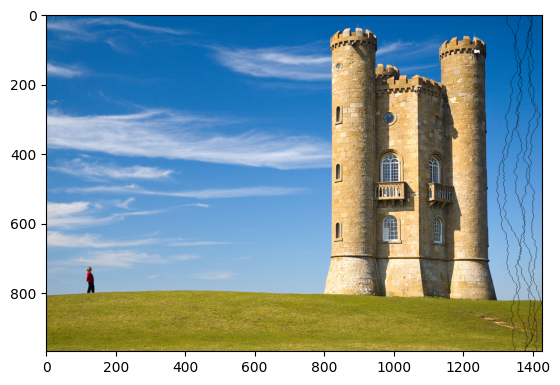

In [ ]:
plt.imshow(image_seams_global,cmap="hot")
plt.show()


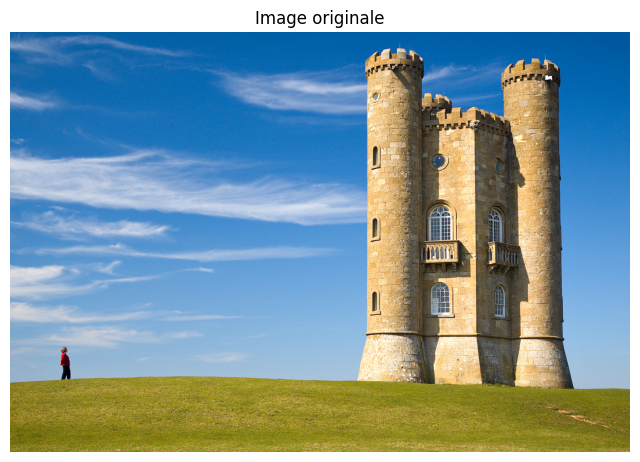

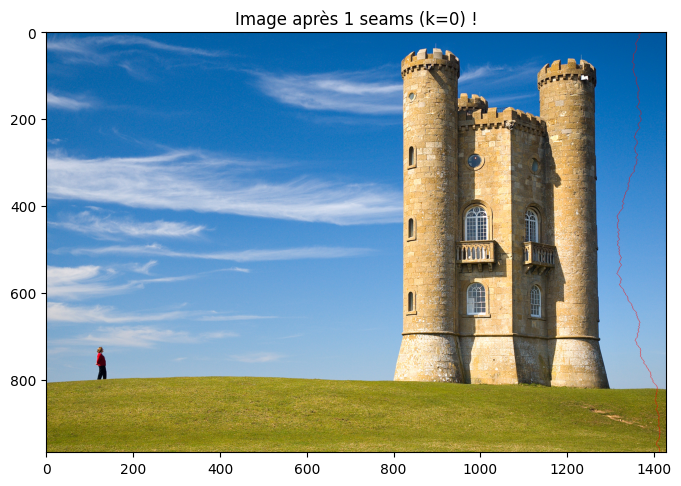

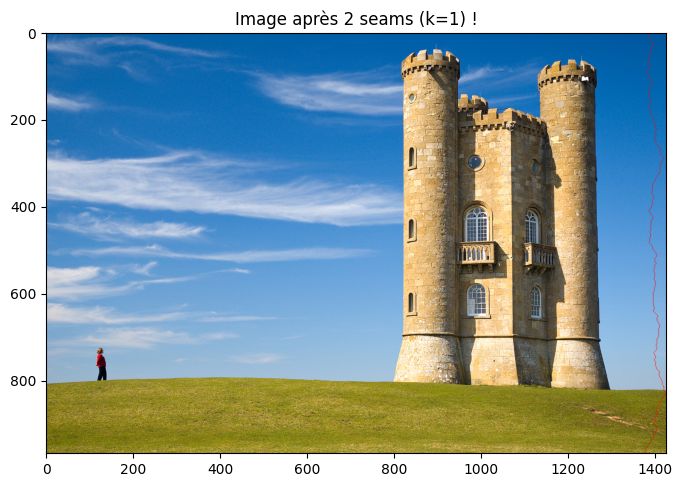

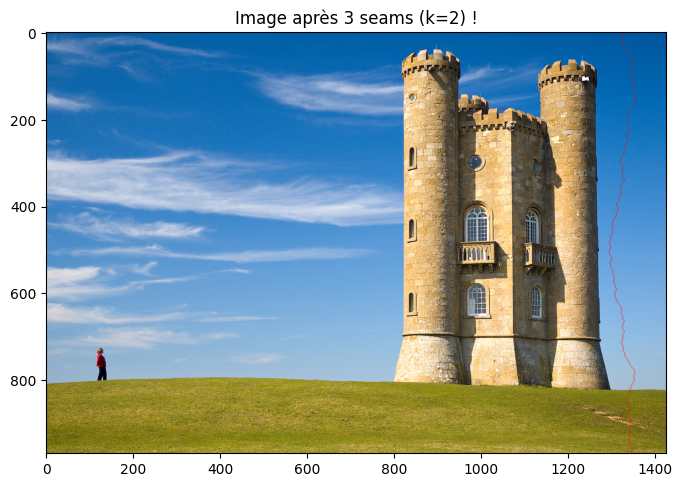

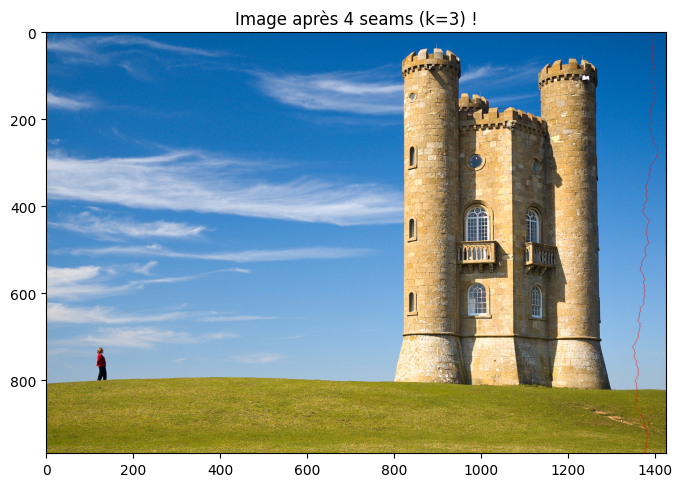

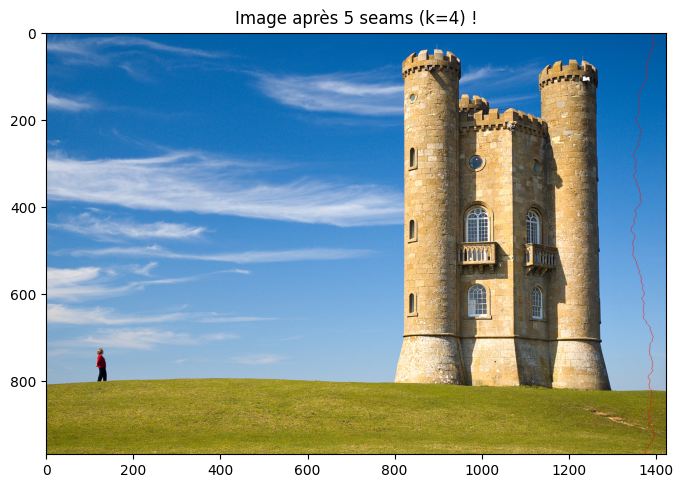

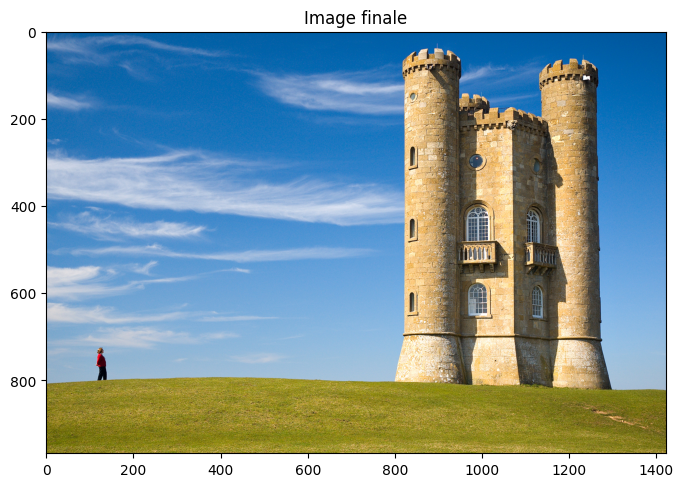

In [ ]:
affichage_final(image2,image_courante,images_intermediaires,5)